# 2.2 Tensorflow Recommenders Basics

In [1]:
import json
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs

Loading the data we saved on project #1:

In [2]:
train_df = pd.read_csv('../local_data/train_data.csv', header=0)[['user','movie','rating']]
test_df = pd.read_csv('../local_data/test_data.csv', header=0)[['user','movie','rating']]
with open('../local_data/metadata.json', 'r') as f:
    metadata = json.load(f)

First thing we'll do is convert the dataframes to Tensorflow datasets:

In [3]:
def convert_to_dataset(df):
    d = {k:v.to_numpy() for k,v in dict(df).items()}
    return tf.data.Dataset.from_tensor_slices(d)

train_dataset = convert_to_dataset(train_df)
test_dataset = convert_to_dataset(test_df)

2021-11-13 12:34:49.974783: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Next, we grab the users and movies vocabularies from the metadata we created:

In [4]:
all_users = [str(int(i)) for i in metadata['users']]
all_movies = [str(int(i)) for i in metadata['movies']]

Now for the model itself. Each tower consists of an input layer, a `StringLookup`, an `Embedding` layer with an additional embedding for OOV and output embeddings of size 25, and a `Dense` layer on-top with 20 nodes. The towers are connected using a `Multiply` layer, followed by another `Dense`, and then the output. Note that as `StringLookup` requires strings as inputs, I cast the model inputs to strings inside `call`.

In [5]:
class RatingPredictionModel(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        
        # User tower
        self.user_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='user_input')
        self.user_sl = tf.keras.layers.StringLookup(vocabulary=all_users, name='user_string_lookup')(self.user_input)
        self.user_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_users)+1, 25, name='user_emb')(self.user_sl), axis=1)
        self.user_dense = tf.keras.layers.Dense(20, activation='relu', name='user_dense')(self.user_emb)
        
        # Movie tower
        self.movie_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='movie_input')
        self.movie_sl = tf.keras.layers.StringLookup(vocabulary=all_movies, name='movie_string_lookup')(self.movie_input)
        self.movie_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_movies)+1, 25, name='movie_emb')(self.movie_sl), axis=1)
        self.movie_dense = tf.keras.layers.Dense(20, activation='relu', name='movie_dense')(self.movie_emb)
        
        # Merging towers
        self.towers_multiplied = tf.keras.layers.Multiply(name='towers_multiplied')([self.user_dense, self.movie_dense])
        self.towers_dense = tf.keras.layers.Dense(10, activation='relu', name='towers_dense')(self.towers_multiplied)
        self.output_node = tf.keras.layers.Dense(1, name='output_node')(self.towers_dense)
        
        # Model definition
        self.model = tf.keras.Model(inputs={'user': self.user_input, 
                                            'movie': self.movie_input}, 
                                    outputs=self.output_node)
        
        self.task = tfrs.tasks.Ranking(
            loss = tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
        
    def call(self, features):
        return self.model({'user': tf.strings.as_string(features["user"]),
                           'movie': tf.strings.as_string(features["movie"])})
    
    def compute_loss(self, features, **kwargs):
        return self.task(labels=features["rating"], predictions=self(features))

Let's train and evaluate the model:

In [6]:
model = RatingPredictionModel()
learning_rate = 2e-3
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
cached_train = train_dataset.shuffle(15_000).batch(10_000).cache()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=5)
model.fit(cached_train, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000


2021-11-13 12:34:50.779740: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


96/96 [==============================] - 5s 40ms/step - root_mean_squared_error: 3.0552 - loss: 9.1658 - regularization_loss: 0.0000e+00 - total_loss: 9.1658
Epoch 2/1000
96/96 [==============================] - 1s 8ms/step - root_mean_squared_error: 1.0423 - loss: 1.0799 - regularization_loss: 0.0000e+00 - total_loss: 1.0799
Epoch 3/1000
96/96 [==============================] - 1s 8ms/step - root_mean_squared_error: 0.9744 - loss: 0.9450 - regularization_loss: 0.0000e+00 - total_loss: 0.9450
Epoch 4/1000
96/96 [==============================] - 1s 8ms/step - root_mean_squared_error: 0.9664 - loss: 0.9293 - regularization_loss: 0.0000e+00 - total_loss: 0.9293
Epoch 5/1000
96/96 [==============================] - 1s 8ms/step - root_mean_squared_error: 0.9650 - loss: 0.9266 - regularization_loss: 0.0000e+00 - total_loss: 0.9266
Epoch 6/1000
96/96 [==============================] - 1s 8ms/step - root_mean_squared_error: 0.9632 - loss: 0.9232 - regularization_loss: 0.0000e+00 - total_loss:

In [7]:
cached_test = test_dataset.batch(5000).cache()
model.evaluate(cached_test, return_dict=True)

11/11 [==============================] - 0s 14ms/step - root_mean_squared_error: 0.9244 - loss: 0.9670 - regularization_loss: 0.0000e+00 - total_loss: 0.9670


{'root_mean_squared_error': 0.9243693947792053,
 'loss': 1.5302753448486328,
 'regularization_loss': 0,
 'total_loss': 1.5302753448486328}

We've reached $RMSE = 0.92$. Very nice!

We'll now plot and save the model.

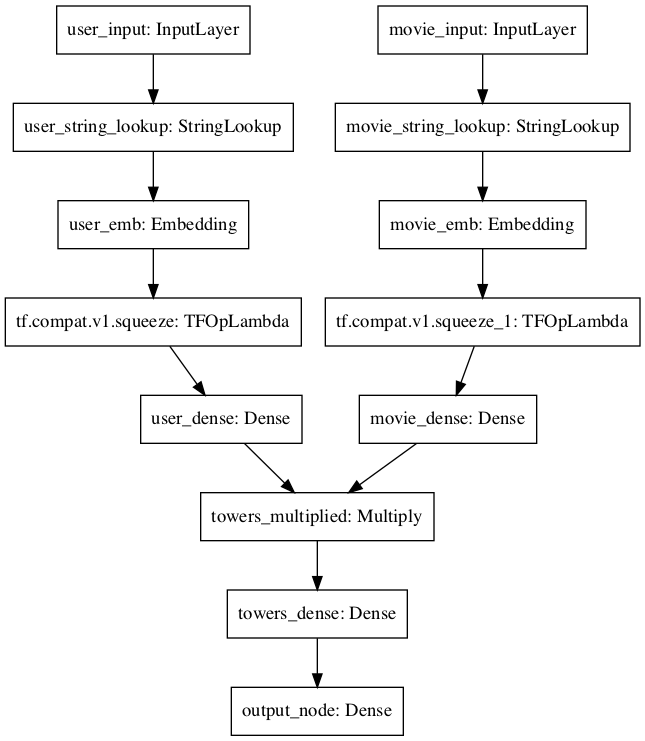

In [8]:
tf.keras.utils.plot_model(model.model, to_file="project_2_2.png")

In [9]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_string_lookup (StringLooku (None, 1)            0           user_input[0][0]                 
__________________________________________________________________________________________________
movie_string_lookup (StringLook (None, 1)            0           movie_input[0][0]                
______________________________________________________________________________________________

In [10]:
model.save_weights('weights_2_2/p22')